In [1]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
import random
from tqdm.auto import tqdm

import tensorflow as tf
import tensorflow.keras as keras

import albumentations as A
AUTOTUNE = tf.data.experimental.AUTOTUNE

/home/ubuntu/anaconda3/envs/machine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##### 경로 설정 ######

DATA_DIR = './data/segmentation'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'validannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')


- [Data augmentation Tensorflow Docs](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko)
- [EfficientNetb3 Docs](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB3)
- [blog](https://hwiyong.tistory.com/397)
- [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- [Albumentations Docs for segmentation](https://albumentations.ai/docs/getting_started/mask_augmentation/)
- [tensorlfow data pipeline bulid](https://www.tensorflow.org/guide/data?hl=ko)

# Albumentation

In [3]:
import albumentations as A
import cv2

augmentation = A.Compose([
    A.Resize(320, 320), 
    A.RandomCrop(width = 128, height=128),
    A.HorizontalFlip(p=0.3)
])

img = cv2.imread('./data/segmentation/train/CASE01_04.png')
mask = cv2.imread('./data/segmentation/trainannot/CASE01_04.png')

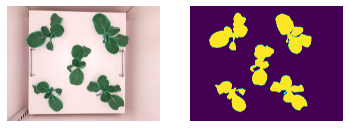

In [4]:
import matplotlib.pyplot as plt
test = [img, mask[..., 0].squeeze()]
fig = plt.figure()
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    ax.imshow(test[i])
    ax.axis('off')
plt.show()

In [27]:
transformed = augmentation(image=img, mask=mask)
t_img = transformed['image']
t_mask = transformed['mask']

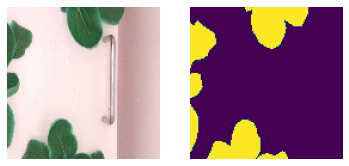

In [28]:
test = [t_img, t_mask[..., 0].squeeze()]
fig = plt.figure()
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    ax.imshow(test[i])
    ax.axis('off')
plt.show()

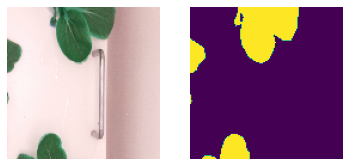

In [29]:
transformed = augmentation(image=img, mask=mask)
t_img = transformed['image']
t_mask = transformed['mask']
test = [t_img, t_mask[..., 0].squeeze()]
fig = plt.figure()
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    ax.imshow(test[i])
    ax.axis('off')
plt.show()

In [30]:
img.shape

(2464, 3280, 3)

In [32]:
t_img.shape

(128, 128, 3)

---

In [4]:
def get_data(data_dir):
    # get image path
    img_path = os.listdir(data_dir)
    try :
        img_path.remove('.ipynb_checkpoints')
    except:
        pass
    img_path_list = [os.path.join(data_dir, x) for x in img_path]
    img_path_list = sorted(img_path_list)
    return img_path_list

In [5]:
##### 경로 설정 ######

DATA_DIR = './data/segmentation'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'validannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')


### data dir  
#x_train_img = tf.data.TextLineDataset(get_data(x_train_dir))
#y_train_img = tf.data.TextLineDataset(get_data(y_train_dir))
x_train_img_dir = get_data(x_train_dir)
y_train_img_dir = get_data(y_train_dir)

x_valid_img_dir = get_data(x_valid_dir)
y_valid_img_dir = get_data(y_valid_dir)

In [6]:
def my_func(img_dir, mask_dir) :
    img = tf.io.read_file(img_dir)
    if img_dir[-3:] == 'png':
        img = tf.io.decode_png(img, channels=3)
    elif img_dir[-3:] == 'jpg':
        img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, [128,128])
    
    mask = tf.io.read_file(mask_dir)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.image.resize(mask, [128,128])
    return img, mask

In [7]:
x_train_img = [] # 원본이미지
y_train_img = [] # 마스크 이미지

x_valid_img = []
y_valid_img = []

In [8]:
for i, m in zip(x_train_img_dir, y_train_img_dir):
    img, mask = my_func(i, m)
    x_train_img.append(img)
    y_train_img.append(mask)

2022-05-03 16:27:38.788426: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-03 16:27:38.791104: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 16:27:38.792994: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
for i, m in zip(x_valid_img_dir, y_valid_img_dir):
    img, mask = my_func(i, m)
    x_valid_img.append(img)
    y_valid_img.append(mask)

In [38]:
img, mask = x_train_img[1], y_train_img[1]

In [10]:
from tensorflow.data import Dataset
x = Dataset.from_tensor_slices(x_train_img)
y = Dataset.from_tensor_slices(y_train_img)

In [11]:
train_dataset = Dataset.zip((x, y))
x = Dataset.from_tensor_slices(x_valid_img)
y = Dataset.from_tensor_slices(y_valid_img)
valid_dataset = Dataset.zip((x, y))

In [12]:
TRAIN_LENGTH = 160
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [13]:
train_dataset2 = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset2 = train_dataset2.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
valid_dataset2 = valid_dataset.batch(BATCH_SIZE)

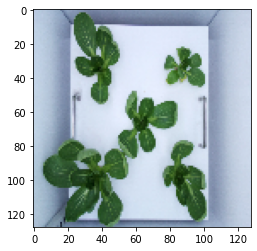

In [146]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
plt.show()

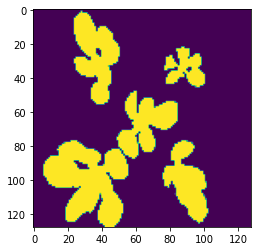

In [147]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
plt.show()

In [54]:
OUTPUT_CHANNELS = 2

In [55]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭시다
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [56]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [59]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링합시다
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 건너뛰기 연결을 업샘플링하고 설정하세요
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 이 모델의 마지막 층입니다
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Binary CrossEntopy

In [63]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),#from_logits=True
              metrics=['accuracy','mse'])

In [64]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_5 (Functional)            [(None, 64, 64, 96), 1841984     input_9[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8, 8, 512)    1476608     model_5[2][4]                    
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 8, 8, 1088)   0           sequential_4[2][0]               
                                                                 model_5[2][3]              

In [65]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 50//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset2, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=valid_dataset2)

Epoch 1/20
2/2 [==============================] - 11s 3s/step - loss: 0.7549 - accuracy: 0.1862 - mse: 1.1730
Epoch 2/20
2/2 [==============================] - 4s 3s/step - loss: 0.1263 - accuracy: 0.1833 - mse: 2.2261
Epoch 3/20
2/2 [==============================] - 5s 2s/step - loss: 0.0460 - accuracy: 0.1724 - mse: 3.1632
Epoch 4/20
2/2 [==============================] - 6s 3s/step - loss: 0.0213 - accuracy: 0.1456 - mse: 4.1887
Epoch 5/20
2/2 [==============================] - 5s 3s/step - loss: 0.0142 - accuracy: 0.1222 - mse: 5.0865
Epoch 6/20
2/2 [==============================] - 5s 2s/step - loss: 0.0140 - accuracy: 0.1082 - mse: 5.8022
Epoch 7/20
2/2 [==============================] - 6s 3s/step - loss: 0.0129 - accuracy: 0.0946 - mse: 6.4494
Epoch 8/20
2/2 [==============================] - 5s 3s/step - loss: 0.0151 - accuracy: 0.0855 - mse: 7.1066
Epoch 9/20
2/2 [==============================] - 5s 2s/step - loss: 0.0143 - accuracy: 0.0825 - mse: 7.5468
Epoch 10/20
2/2 [=

In [66]:
test = './data/test/image/001.png'
def load_test_img(img_dir):
    img = tf.io.read_file(img_dir)
    if img_dir[-3:] == 'png':
        img = tf.io.decode_png(img, channels=3)
    elif img_dir[-3:] == 'jpg':
        img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, [128,128])
    return img
test = load_test_img(test)

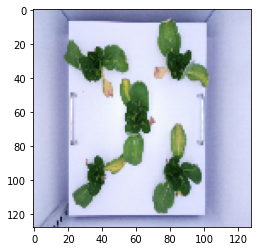

In [67]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(test))
plt.show()

In [68]:
test.shape

TensorShape([128, 128, 3])

In [69]:
test_dataset = Dataset.from_tensor_slices([[test]])
pred = model.predict(test_dataset)

In [70]:
type(pred)

numpy.ndarray

In [71]:
pred[0].shape

(128, 128, 2)

In [72]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(pred[..., 1:]))
plt.show()

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (1, 128, 128, 1)

---
AUGMENTATION 추가

In [32]:
# heavy augmentation
original_height, original_width = 128, 128
aug = A.Compose([
    A.Resize(128, 128), 
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
        A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
    ], p=1),    
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8)])

random.seed(11)

In [33]:
aug_x_train = []
aug_y_train = []

for i, m in zip(x_train_img_dir, y_train_img_dir):
    img = cv2.imread(i)
    mask = cv2.imread(m)
    augmentation = aug(image= img, mask=mask)
    aug_x_train.append(augmentation['image']/255.)
    aug_y_train.append(augmentation['mask']/255.)

In [38]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(tf.keras.preprocessing.image.array_to_img(mask))
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

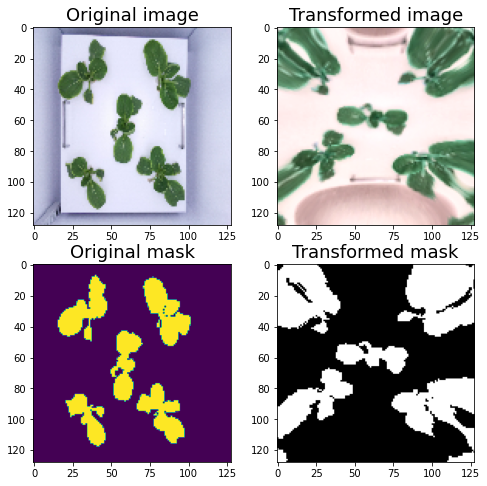

In [39]:
visualize(aug_x_train[0], aug_y_train[0], x_train_img[0], y_train_img[0])

In [40]:
x = Dataset.from_tensor_slices(aug_x_train)
y = Dataset.from_tensor_slices(aug_y_train)
aug_train_dataset = Dataset.zip((x, y))
aug_train_dataset = aug_train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
aug_train_dataset = aug_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [43]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 50//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset2, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=valid_dataset2)

Epoch 1/20
2/2 [==============================] - 5s 2s/step - loss: 0.0000e+00 - accuracy: 0.5741
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 0.5712
Epoch 3/20
2/2 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 0.5758
Epoch 4/20
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 0.5844
Epoch 5/20
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 0.5751
Epoch 6/20
2/2 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 0.5581
Epoch 7/20
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 0.5791
Epoch 8/20
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 0.5682
Epoch 9/20
2/2 [==============================] - 3s 1s/step - loss: 0.0000e+00 - accuracy: 0.5721
Epoch 10/20
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 0.5819
Epoch 11/

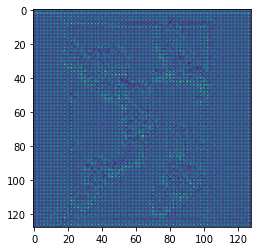

In [44]:
pred = model.predict(test_dataset)

plt.imshow(tf.keras.preprocessing.image.array_to_img(pred[0]))
plt.show()

### 다른모델

In [221]:
!pip install -U --pre segmentation-models --user

In [223]:
import segmentation_models as sm

ModuleNotFoundError: No module named 'segmentation_models'